In [1]:
import os
import isx

In [2]:
data_dir   = 'D:\\Calcium imaging\\20190205\\20190205_left\\Session-20190205-102719'
output_dir = 'D:\\Calcium imaging\\Inscopix_Projects\\20190205\\20190205_data_API'
isxd_files = ['2019-02-05-11-00-04_video_recovered.isxd',
              #'2019-02-05-11-18-22_video_recovered.isxd', this file is broken
              '2019-02-05-11-37-44_video_recovered.isxd']
rec_files  = [os.path.join(data_dir, name) for name in isxd_files]

os.makedirs(output_dir, exist_ok=True)

proc_movie_files = []
proc_cs_files = []

In [3]:
pp_files = isx.make_output_file_paths(rec_files, output_dir, 'PP')
isx.preprocess(rec_files, pp_files, spatial_downsample_factor=2)

In [4]:
bp_files = isx.make_output_file_paths(pp_files, output_dir, 'BP')
isx.spatial_filter(pp_files, bp_files, low_cutoff=0.005, high_cutoff=0.500)

In [6]:
# Motion correct the movies using the mean projection as a reference frame.
mean_proj_file = os.path.join(output_dir,'2019-02-05-mean-image.isxd')
isx.project_movie(bp_files, mean_proj_file, stat_type='mean')

In [9]:
mc_files = isx.make_output_file_paths(bp_files, output_dir, 'MC')
translation_files = isx.make_output_file_paths(mc_files, output_dir, 'translations', 'csv')
crop_rect_file = os.path.join(output_dir,'2019-02-05-crop-rect.csv')
isx.motion_correct(bp_files, mc_files, max_translation=20,reference_file_name=mean_proj_file,
                   low_bandpass_cutoff=None, high_bandpass_cutoff=None,
                   output_translation_files=translation_files, 
                   output_crop_rect_file=crop_rect_file)

In [10]:
dff_files = isx.make_output_file_paths(mc_files, output_dir, 'DFF')
isx.dff(mc_files, dff_files, f0_type='mean')

In [11]:
# Run PCA-ICA on the DF/F movies.
# Note that you will have to manually determine the number of cells
# Increase the block_size to increase speed at the expense of more memory usage.
ic_files = isx.make_output_file_paths(dff_files, output_dir, 'PCA-ICA')
num_cells = 180
isx.pca_ica(dff_files, ic_files, num_cells, int(1.15*num_cells),
            block_size=1000)

False

In [12]:
# Run event detection on the PCA-ICA cell sets.
event_files = isx.make_output_file_paths(ic_files, output_dir, 'ED')
isx.event_detection(ic_files, event_files, threshold=5)

In [13]:
# Automatically accept and reject cells based on their cell metrics
# Only accept cells that have a nonzero event rate, an SNR greater
# than 3, and only one connected component after thresholding
auto_ar_filters = [('SNR', '>', 3), ('Event Rate', '>', 0), ('# Comps', '=', 1)]
isx.auto_accept_reject(ic_files, event_files, filters=auto_ar_filters)

In [14]:
# Store the processed movies and cell sets for longitudinal registration.
proc_movie_files += dff_files
proc_cs_files += ic_files

In [16]:
# Perform longitudinal registration on the processed movies and cell sets
# to align the two days of data.
lr_cs_files = isx.make_output_file_paths(proc_cs_files, output_dir, 'LR')
lr_movie_files = isx.make_output_file_paths(proc_movie_files, output_dir, 'LR')
lr_csv_file = os.path.join(output_dir, 'LR.csv')
isx.longitudinal_registration(
proc_cs_files, lr_cs_files, input_movie_files=proc_movie_files,
output_movie_files=lr_movie_files, csv_file=lr_csv_file, accepted_cells_only=True)

In [18]:
cell_set = isx.CellSet.read('D:\\Calcium imaging\\Inscopix_Projects\\20190205\\20190205_data_API\\2019-02-05-11-37-44_video_recovered-PP-BP-MC-DFF-PCA-ICA.isxd')
image_0 = cell_set.get_cell_image_data(0)
trace_0 = cell_set.get_cell_trace_data(0)

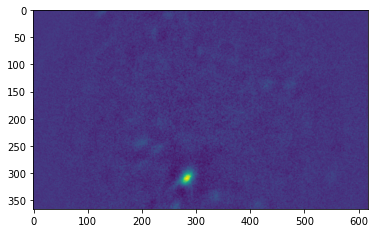

In [20]:
import matplotlib.pyplot as plt
plt.imshow(image_0)

In [24]:
isx.examples.cnmfe

AttributeError: module 'isx' has no attribute 'examples'

In [27]:
import isx.examples.cnmfe

In [30]:
isx.examples.cnmfe.__dict__

{'__name__': 'isx.examples.cnmfe',
 '__doc__': '\n    This module contains an example for running CNMFe through CaImAn.\n',
 '__package__': 'isx.examples',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x1c6803f61c8>,
 '__spec__': ModuleSpec(name='isx.examples.cnmfe', loader=<_frozen_importlib_external.SourceFileLoader object at 0x000001C6803F61C8>, origin='C:\\Program Files\\Inscopix\\Data Processing\\isx\\examples\\cnmfe.py'),
 '__file__': 'C:\\Program Files\\Inscopix\\Data Processing\\isx\\examples\\cnmfe.py',
 '__cached__': 'C:\\Program Files\\Inscopix\\Data Processing\\isx\\examples\\__pycache__\\cnmfe.cpython-37.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.",
  '__package__': '',
  '__loader__': _frozen_importlib.BuiltinImporter,
  '__spec__': ModuleSpec(name='builtins', loader=<class '_frozen_importlib.BuiltinImporter'>

In [31]:
import isx.cnmfe

In [32]:
help(isx.cnmfe.run_cnmfe)

Help on function run_cnmfe in module isx.cnmfe:

run_cnmfe(input_movie_files, output_cell_set_files, output_events_files, num_processes=1, overwrite_tiff=False, K=20, rf=[25, 25], stride=6, gSiz=13, gSig=5, min_pnr=5, min_corr=0.8, ssub_B=1, min_SNR=5, rval_thr=0.85, decay_time=0.4, event_threshold=0.025, merge_threshold=0.8, output_dir=None)
    Run the CaImAn CNMFe algorithm on an input movie file.
    
    Arguments
    ---------
    input_movie_files : list<str>
        Path to an .isxd movie file, or a list of paths to .isxd movie files that are a part of a Series.
    output_cell_set_files : list<str>
        The path to a cell set .isxd file that will be written with the identified traces and footprints, or if
        there are multiple input movie files, a list of output cell set file paths.
    output_events_files : list<str>
        The path to an events .isxd file that will be written with the deconvolved spikes of each neuron, or if there
        are multiple input movie fi